Importing the required libraries

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D
from tensorflow.keras.layers import Input,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.callbacks import EarlyStopping

Loading and Preprocessing of the dataset

In [11]:
train = list(os.walk(r"D:\MUJ\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\Mask_Dataset\train"))

In [12]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}


In [13]:
def dataset(path): 
    images = []
    labels = []
    for folder in os.listdir(path):
        value_of_label = dict_labels[folder] 

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset(r"D:\MUJ\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\Mask_Dataset\train")
images, labels = shuffle(images, labels)

In [14]:
images.shape

(2282, 224, 224, 3)

In [15]:
labels.shape

(2282,)

Distribution of the dataset

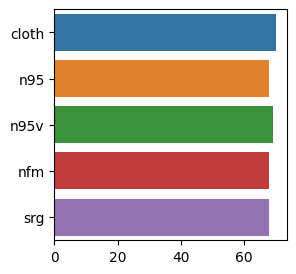

In [16]:
types_of_mask= train[0][1]
no_of_masks = []
for _ in range(1,6):
    no_of_masks.append(len(train[_][0]))
plt.figure(figsize = (3,3))
sns.barplot(y = types_of_mask, x = no_of_masks);

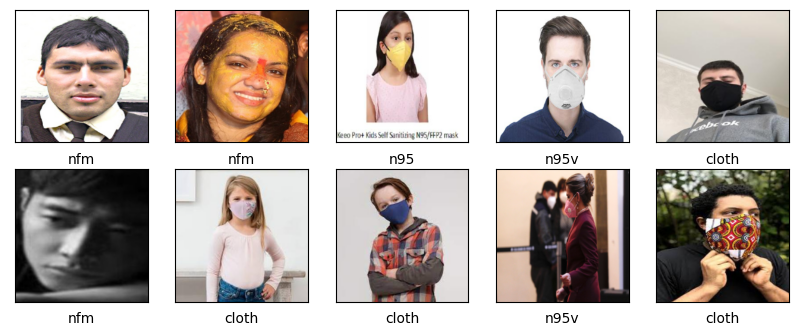

In [17]:
plt.figure(figsize = (10,10))
for _ in range(10):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

Data Augmentation

In [18]:
image_size = (224, 224)
batch_size = 32
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.15)

In [20]:
train_ds = train_datagen.flow_from_directory(r"D:\MUJ\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\Mask_Dataset\train",
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb")

val_ds = train_datagen.flow_from_directory(r"D:\MUJ\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\Mask_Dataset\train",
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 1943 images belonging to 5 classes.
Found 339 images belonging to 5 classes.


In [21]:
train_ds.class_indices

{'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}

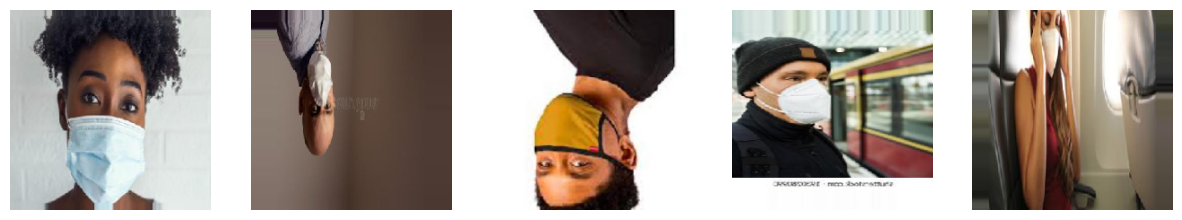

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

Transfer Learning MobileNetModelV2


In [13]:
m_model=tf.keras.applications.MobileNetV2()

2022-11-02 04:41:34.767823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 04:41:34.936987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 04:41:34.938306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 04:41:34.940507: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

14548992/14536120 [==============================] - 0s 0us/step


In [14]:
inputs = Input(shape=(224, 224, 3))
basem_input=m_model.layers[0].input
basem_output=m_model.layers[-2].output

In [15]:
finalm_output = layers.Dense(128)(basem_output)
finalm_ouput= layers.Activation('relu')(finalm_output)
finalm_output = layers.Dense(64)(finalm_ouput)
finalm_ouput = layers.Activation('relu')(finalm_output)
finalm_output = layers.Dense(5,activation='softmax')(finalm_ouput)

In [16]:
mob_model = keras.Model(inputs=basem_input,outputs=finalm_output)

In [17]:
mob_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [18]:
mob_model.compile(loss="categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

In [19]:
early_stopping = EarlyStopping(monitor='val_loss',
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

callback = [early_stopping]

In [20]:
mob_hist=mob_model.fit(train_ds, epochs=15, validation_data=val_ds,callbacks=[callback])

2022-11-02 04:41:39.811161: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-11-02 04:41:44.760101: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


52/52 [==============================] - 39s 541ms/step - loss: 1.0857 - accuracy: 0.5781 - val_loss: 1.0291 - val_accuracy: 0.5319
Epoch 2/15
52/52 [==============================] - 27s 527ms/step - loss: 0.5708 - accuracy: 0.8023 - val_loss: 0.6988 - val_accuracy: 0.7021
Epoch 3/15
52/52 [==============================] - 27s 524ms/step - loss: 0.3890 - accuracy: 0.8534 - val_loss: 0.5522 - val_accuracy: 0.8085
Epoch 4/15
52/52 [==============================] - 28s 526ms/step - loss: 0.2861 - accuracy: 0.8972 - val_loss: 0.3991 - val_accuracy: 0.8298
Epoch 5/15
52/52 [==============================] - 27s 523ms/step - loss: 0.2346 - accuracy: 0.9147 - val_loss: 0.7153 - val_accuracy: 0.7660
Epoch 6/15
52/52 [==============================] - 27s 517ms/step - loss: 0.1898 - accuracy: 0.9315 - val_loss: 0.5118 - val_accuracy: 0.7872
Epoch 7/15
52/52 [==============================] - 26s 504ms/step - loss: 0.1749 - accuracy: 0.9429 - val_loss: 0.5012 - val_accuracy: 0.8511
Restoring 

Training Accuracy Graphs

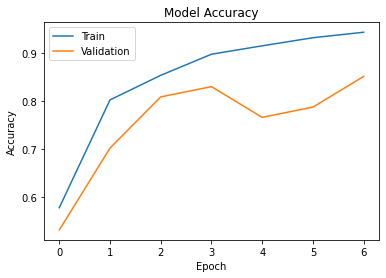

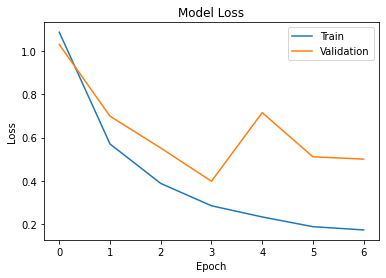

In [21]:
import matplotlib.pyplot as plt
plt.plot(mob_hist.history['accuracy'])
plt.plot(mob_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc=0)
plt.show()


plt.plot(mob_hist.history['loss'])
plt.plot(mob_hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc=0)
plt.show()


Transfer Learning ResNet50

In [22]:
model = applications.ResNet50V2()
inputs = Input(shape=(224, 224, 3))

base_input = model.layers[0].input
base_output = model.layers[-2].output
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dropout(0.5)(final_output)
final_output = layers.Dense(64)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dropout(0.3)(final_output)
final_output = layers.Dense(5,activation='softmax')(final_output)

new_model = keras.Model(inputs = base_input , outputs=final_output)
new_model.summary()

102883328/102869336 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________

In [23]:
new_model.compile(loss="categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

In [24]:
early_stopping = EarlyStopping(monitor='val_loss',
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

callback = [early_stopping]

In [25]:
res_hist=new_model.fit(train_ds, epochs=15, validation_data=val_ds,callbacks=[callback])

Epoch 1/15
52/52 [==============================] - 33s 547ms/step - loss: 1.1791 - accuracy: 0.5072 - val_loss: 0.7580 - val_accuracy: 0.7447
Epoch 2/15
52/52 [==============================] - 27s 510ms/step - loss: 0.6935 - accuracy: 0.7518 - val_loss: 0.4355 - val_accuracy: 0.8723
Epoch 3/15
52/52 [==============================] - 27s 513ms/step - loss: 0.4750 - accuracy: 0.8341 - val_loss: 0.2581 - val_accuracy: 0.8936
Epoch 4/15
52/52 [==============================] - 27s 525ms/step - loss: 0.3560 - accuracy: 0.8906 - val_loss: 0.3236 - val_accuracy: 0.9149
Epoch 5/15
52/52 [==============================] - 27s 520ms/step - loss: 0.3143 - accuracy: 0.8948 - val_loss: 0.2122 - val_accuracy: 0.9362
Epoch 6/15
52/52 [==============================] - 27s 514ms/step - loss: 0.2693 - accuracy: 0.9050 - val_loss: 0.3623 - val_accuracy: 0.8723
Epoch 7/15
52/52 [==============================] - 27s 520ms/step - loss: 0.2110 - accuracy: 0.9273 - val_loss: 0.3313 - val_accuracy: 0.8936

Accuracy Graphs

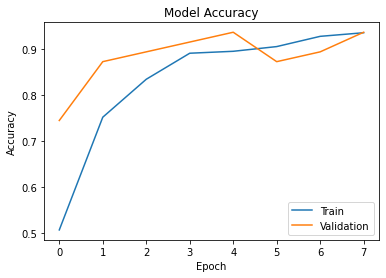

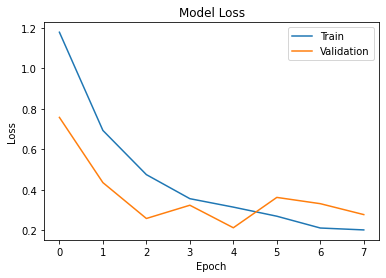

In [26]:
import matplotlib.pyplot as plt
plt.plot(res_hist.history['accuracy'])
plt.plot(res_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc=0)
plt.show()


plt.plot(res_hist.history['loss'])
plt.plot(res_hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc=0)
plt.show()


In [23]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nSpecies: {1}'.format(clas, name))

In [45]:
predictor(r"../input/face-mask-types-dataset/Dataset/test/cloth/396.jpg", new_model)

NameError: name 'new_model' is not defined

The given image is of 
Class: 1 
Species: n95


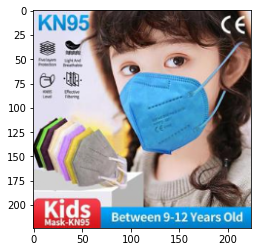

In [29]:
predictor(r"../input/face-mask-types-dataset/Dataset/test/n95/355.jpg", new_model)

The given image is of 
Class: 3 
Species: nfm


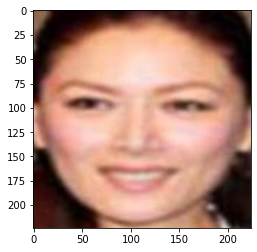

In [30]:
predictor(r"../input/face-mask-types-dataset/Dataset/test/nfm/782.png", new_model)

The given image is of 
Class: 2 
Species: n95v


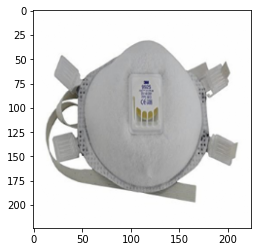

In [31]:
predictor(r"../input/face-mask-types-dataset/Dataset/test/n95v/418.png", new_model)

The given image is of 
Class: 4 
Species: srg


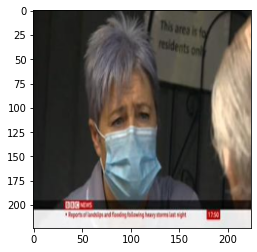

In [32]:
predictor(r"../input/face-mask-types-dataset/Dataset/test/srg/343.jpg", new_model)

Saving the model

In [33]:
new_model.save('Face_Mask_Detection.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Predicting from the saved Model

In [25]:
modelSaved = keras.models.load_model('Face_Mask_Detection.h5') 

In [27]:
frame = cv2.imread(r"D:\MUJ\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\test.jpg")

In [28]:
frame.shape

(768, 812, 3)

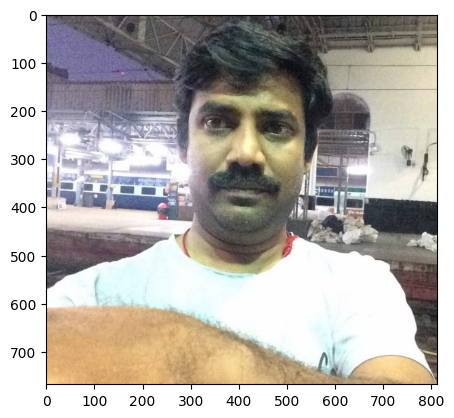

In [29]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [30]:
final_image = cv2.resize(frame,(224,224))
final_image = np.expand_dims(final_image, axis=0) 
final_image = final_image/255.0

In [31]:
Predictions = modelSaved.predict(final_image)

1/1 [==============================] - 2s 2s/step


In [32]:
Predictions.argmax()

3

In [33]:
train_ds.class_indices

{'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}

Using Haarcascade Frontal Face through openCV and predicting the classesPredicting from the saved Model

In [34]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [35]:
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

In [36]:
gray.shape

(768, 812)

In [37]:
faces = faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = frame[y:y+h,x:x+w]
    cv2.rectangle(frame,(x,y),(x+w,y+h),(225,0,0),2)
    faces = faceCascade.detectMultiScale(roi_gray)
    if len(faces)==0:
        print("Face not detected")
    else:
        for(ex,ey,ew,eh) in faces:
            face_roi = roi_color[ey:ey+eh,ex:ex+ew]

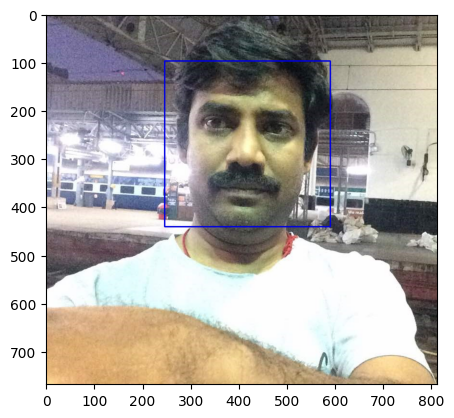

In [38]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

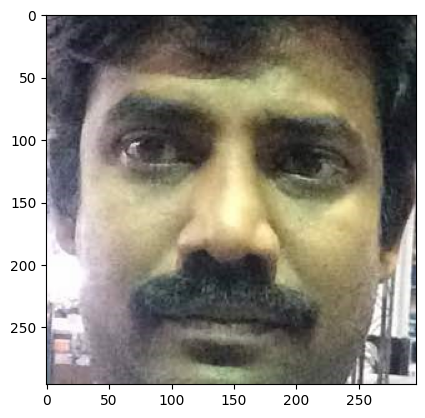

In [39]:
plt.imshow(cv2.cvtColor(face_roi,cv2.COLOR_BGR2RGB))

In [40]:
Predictions = modelSaved.predict(final_image)

1/1 [==============================] - 0s 235ms/step


In [41]:
Predictions

array([[2.8193470e-03, 1.5594997e-05, 6.1511993e-05, 9.9691975e-01,
        1.8389868e-04]], dtype=float32)

In [42]:
Predictions.argmax()

3

In [43]:
train_ds.class_indices

{'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}

Realtime Face mask Classifier 

In [44]:
from turtle import color
import numpy as np
import cv2
from cv2 import rectangle
from cv2 import putText
from grpc import Status
path = 'haarcascade_frontalface_default.xml'
font_scale =1.5
font = cv2.FONT_HERSHEY_PLAIN

rectangle_bgr = (255,255,255)
img = np.zeros((500,500))
text ="Some text in a box!"
(text_width,text_height) = cv2.getTextSize(text,font ,fontScale = font_scale,thickness=1)[0]
text_offset_x =10
text_offset_y = img.shape[0] - 25
box_coords = ((text_offset_x,text_offset_y),(text_offset_x+text_width+2,text_offset_y-text_height-2))
cv2.rectangle(img,box_coords[0],box_coords[1],rectangle_bgr,cv2.FILLED)
cv2.putText(img,text,(text_offset_x,text_offset_y),font,fontScale=font_scale,color=(0,0,0),thickness=1)

cap =cv2.VideoCapture(1)
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("cant open webcam")

while True:
    ret,frame=cap.read()
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces=faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = frame[y:y+h,x:x+w]
        cv2.rectangle(frame,(x,y),(x+w,y+h),(225,0,0),2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess)==0:
            print("Face not detected")
        else:
            for(ex,ey,ew,eh) in facess:
                face_roi = roi_color[ey:ey+eh,ex:ex+ew]

    final_image = cv2.resize(face_roi,(224,224))
    final_image = np.expand_dims(final_image, axis=0) 
    final_image = final_image/255.0

    font = cv2.FONT_HERSHEY_SIMPLEX

    Predictions =modelSaved.predict(final_image)

    font_scale =1.5
    font = cv2.FONT_HERSHEY_PLAIN

    if(np.argmax(Predictions)==0):
        status ="cloth"

        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255),2)
        cv2.putText(frame,status,(100,150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif(np.argmax(Predictions)==1):
        status ="n95"

        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255),2)
        cv2.putText(frame,status,(100,150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif(np.argmax(Predictions)==2):
        status ="n95v"

        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255),2)
        cv2.putText(frame,status,(100,150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif(np.argmax(Predictions)==3):
        status ="nfm"

        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255),2)
        cv2.putText(frame,status,(100,150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    else:
        status ="srg"

        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255),2)
        cv2.putText(frame,status,(100,150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    cv2.imshow('Face Mask Type',frame)
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 144ms/step
